# Model selection using information criteria

author: Audrey Olivier

Theory background: model selection refers to the task of selecting a statistical model from a set of candidate models, given some data. A good model is amodel that is able to explain the data well (high model evidence). Given models of same explanatory power, the simplest model should be chosen (Ockam razor). Several simple criteria can be used to compute a model's quality and thus perform model selection. UQpy implements three citeria: 
<br>
Bayesian information criterion (BIC)
$$ BIC = ln(n) k - 2 ln(\hat{L}) $$

Akaike information criterion (AIC)
$$ AIC = 2 k - 2 ln (\hat{L})  $$

Corrected formula for AIC (AICc), for small data sets 
$$ AICc = AIC + \frac{2k(k+1)}{n-k-1} $$

For all formula above, $k$ is the number of parameters characterizing the model, $\hat{L}$ is the maximum value of the likelihood function and $n$ the number of data points. The best model is the one that minimizes the cirterion. All three formulas have a model fit term (find the model that minimizes the negative log likelihood) and a penalty term that increases as the number of model parameters (model complexity) increases.

Reference: *Burnham, K. P.; Anderson, D. R. (2002), Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach (2nd ed.), Springer-Verlag, ISBN 0-387-95364-7*

## Example 1: selection between different univariate distributions

In [1]:
# import the required packages
from UQpy.Inference import Model, InfoModelSelection
from UQpy.RunModel import RunModel
import numpy as np
import matplotlib.pyplot as plt

Generate data using a gamma distribution.

In [2]:
from scipy.stats import gamma
data = gamma(a = 2, loc = 0, scale = 1).rvs(size=200)
print(data.shape)

(200,)


Define the models to be compared, then call InfoModelSelection to perform model selection. By default, InfoModelSelection returns its outputs, fitted parameters, value of the chosen criteria, model probabilities and so on, in a sorted order, i.e., starting with the most probable model. However, if setting sorted_ouputs=False, the class output attributes are given in the same order as the candidate_models.

In [3]:
# Define the models to be compared, for each model one must create an instance of the model class
model_names = ['exponential', 'gamma', 'chisquare']
n_params_list = [2, 3, 3]
candidate_models = []
for i, model_name in enumerate(model_names):
    M = Model(model_name = model_name, model_type = 'pdf', n_params=n_params_list[i])
    candidate_models.append(M)

Sorted model using BIC criterion: gamma, chisquare, exponential
Sorted model using AIC criterion: gamma, chisquare, exponential
Sorted model using AICc criterion: gamma, chisquare, exponential


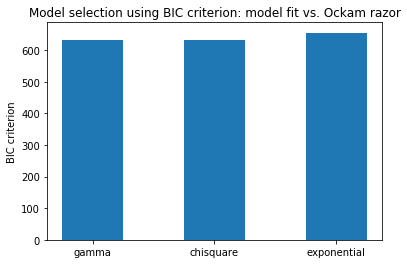

Shape parameter of the gamma distribution: 1.968642506739561
DoF of the chisquare distribution: 3.937370013180638


In [4]:
# Perform model selection using different information criteria
criteria = ['BIC', 'AIC', 'AICc']
for criterion in criteria:
    selector = InfoModelSelection(candidate_models = candidate_models, 
                                  data = data, method = criterion, sorted_outputs=True)
    print('Sorted model using '+criterion+' criterion: '+', '.join(x for x in 
                                                                   selector.model_names))
    if criterion == 'BIC':
        criterion_value = selector.criteria
        sorted_names = selector.model_names
        param = selector.fitted_params
        
width = 0.5
ind = np.arange(len(sorted_names))
p1 = plt.bar(ind, criterion_value, width = width)
#p2 = plt.bar(ind, criterion_value-data_fit_value, bottom=data_fit_value, width = width)

plt.ylabel('BIC criterion')
plt.title('Model selection using BIC criterion: model fit vs. Ockam razor')
plt.xticks(ind, sorted_names)
#plt.legend((p1[0], p2[0]), ('Data fit', 'Ockam razor'))

plt.show()

print('Shape parameter of the gamma distribution: {}'.format(param[sorted_names.index('gamma')][0]))
print('DoF of the chisquare distribution: {}'.format(param[sorted_names.index('chisquare')][0]))

Note that here both the chisquare and gamma are capable of explaining the data, with $a = \nu/2$, $a$ is gamma's shape parameter and $\nu$ is the number of DOFs in chi-square distribution.

## Example 2: model selection in regression -  $y=X \theta + \epsilon$

In [5]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_0', 'theta_1'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[  1.46346223  -0.84839089   1.79803412   3.09994006   1.23953903
   3.6247401    5.06543553   7.34941704   6.82858723   7.4789733
   9.83907142  11.42700118  14.39546033  17.38525637  20.19520895
  22.83695754  24.54899198  29.25286322  29.65760691  34.16793272
  37.24091842  41.40341605  45.18470234  48.61199669  55.80207637
  57.27327252  60.86410065  65.75616888  70.48348188  79.05067876
  82.04702284  86.69254597  91.75511088  95.45200908 103.47291766
 110.83356432 114.87129555 123.14676402 129.25846286 134.8104599
 141.33047849 150.03873357 156.89622855 162.35881076 171.29009904
 178.21756846 185.41560196 193.94018908 203.27433145 210.13401387]


In [6]:
# Create instances of the Model class for three models: linear, quadratic and cubic
names = ['linear', 'quadratic', 'cubic']
candidate_models = []
for i in range(3):
    M = Model(model_type='python', n_params=i+1,
              model_script='pfn_models.py', model_object_name = 'model_'+names[i],
              model_name=names[i], error_covariance=error_covariance)
    candidate_models.append(M)

Apart from the data, candidate models and method (BIC, AIC...), InfoModelSelection also takes as inputs lists of inputs to the maximum likelihood class (iter_optim, method_optim, ...). Those inputs should be lists of length len(candidate_models).

In [7]:
# Perform model selection using BIC criterion
selector = InfoModelSelection(candidate_models = candidate_models, data = data, method = 'BIC', 
                              method_optim=['nelder-mead']*3, sorted_outputs=True)
print('Sorted models: ', selector.model_names)
print('Value of criteria: ', selector.criteria)
print('Value of penalty term (complexity)', selector.penalty_terms)
print(selector.probabilities)

Sorted models:  ['quadratic', 'cubic', 'linear']
Value of criteria:  [153.5571593830961, 157.43613515729393, 25776.809793442193]
Value of penalty term (complexity) [7.824046010856292, 11.736069016284437, 3.912023005428146]
[0.8742958717326227, 0.1257041282673773, 0.0]


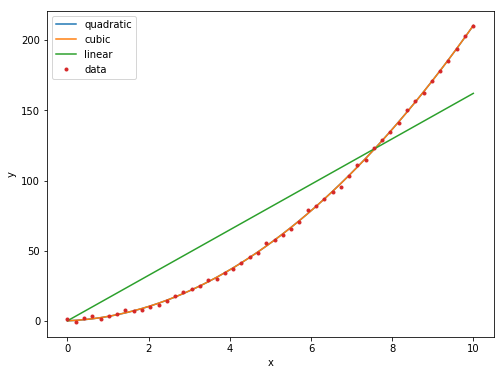

In [8]:
# Plot the results
domain = np.linspace(0, 10, 50)
fig, ax = plt.subplots(figsize=(8,6))

var_names = ['theta_0', 'theta_1']
for i in range(3):
    var_names = ['theta {}'.format(j) for j in range(i+1)]
    z = RunModel(samples=selector.fitted_params[i].reshape((1,-1)), 
                 model_object_name = 'model_'+selector.model_names[i],
                 model_script='pfn_models.py')
    y = z.qoi_list[0].reshape((-1,))
    ax.plot(domain, y, label = selector.model_names[i])

plt.plot(domain, data, linestyle='none', marker='.', label='data')
plt.xlabel('x')
plt.ylabel('y')
    
plt.legend()
plt.show()

For this case, one can observe that both the quadratic and cubic model are capable of explaining the data. The cubic model is penalized due to its higher complexity (penalty_term) and thus the quadratic model is preferred.